<h2><center>Train Models</center></h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np

In [2]:
# Load the cleaned data
"""
This data clened as below
- Removed the rows with missing values
- Removed the rows with '?' values
- Removed the rows with duplicate values
- Removed education_num and capital-loss columns
- Outliers handles with Winsorization
- Label encoded the categorical

"""

df = pd.read_csv('../Data/adult_cleaned_winsorized_label_encoded.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,income
0,39,5,77516,9,4,0,1,4,1,2174,40,38,0
1,50,4,83311,9,2,3,0,4,1,0,20,38,0
2,38,2,215646,11,0,5,1,4,1,0,40,38,0
3,53,2,234721,1,2,5,0,2,1,0,40,38,0
4,28,2,338409,9,2,9,5,2,0,0,40,4,0


In [4]:
# Split to X and y
X = df.drop(columns=['income'])
y = df['income']

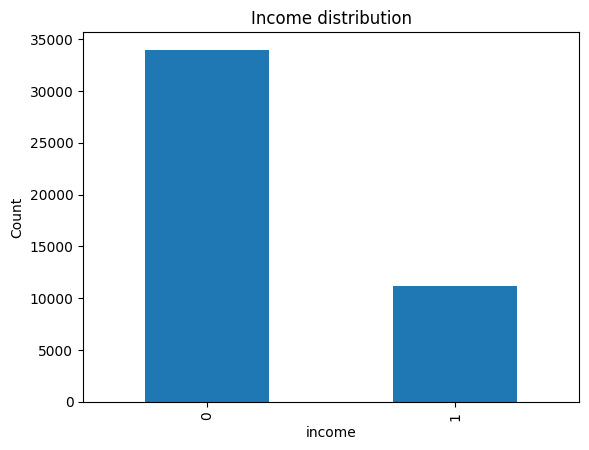

In [5]:
y.value_counts().plot(kind='bar')
plt.title('Income distribution')
plt.ylabel('Count')
plt.show()

As we can see the dataset is imbalanced. It will cause to the model performance. Therefore the dataset will be balanced with oversampling technique.

### SMOTE (Synthetic Minority Over-sampling Technique)

This technique works by generating synthetic samples in the minority class by interpolating between existing minority class instances.

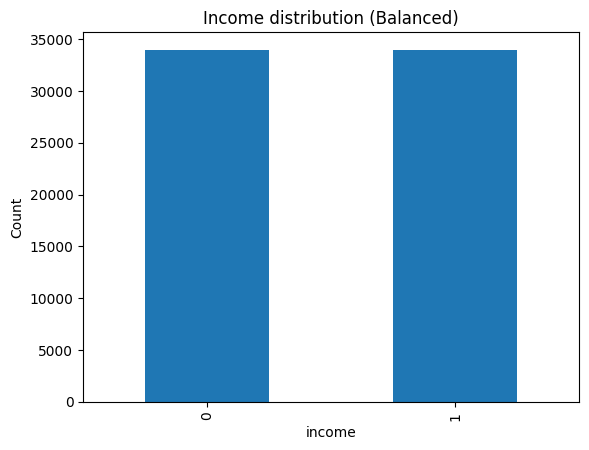

In [6]:
# Over sampling
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts().plot(kind='bar')
plt.title('Income distribution (Balanced)')
plt.ylabel('Count')
plt.show()

In [7]:
# Split to train and test

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [8]:
X_train.shape, X_test.shape

((54356, 12), (13590, 12))

In [9]:
y_train.value_counts()

income
0    27227
1    27129
Name: count, dtype: int64

### Train the Random Forest Model and Hyper Parameter Optimization with KFold Cross Validations

In [10]:
model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 40, 30]
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score found: ", grid_search.best_score_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 200}
Best accuracy score found:  0.8763521419734774


In [11]:
best_rf_classifier = grid_search.best_estimator_

In [12]:
y_pred = best_rf_classifier.predict(X_test)
y_pred_train = best_rf_classifier.predict(X_train)

print(classification_report(y_test, y_pred))
print("Test accuracy score: ", accuracy_score(y_test, y_pred))
print("Train accuracy score: ", accuracy_score(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6746
           1       0.87      0.89      0.88      6844

    accuracy                           0.88     13590
   macro avg       0.88      0.88      0.88     13590
weighted avg       0.88      0.88      0.88     13590

Test accuracy score:  0.8822663723325975
Train accuracy score:  0.9930274486717198


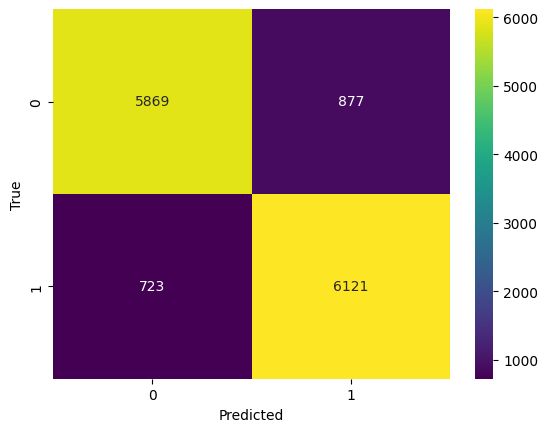

In [13]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Receiver Operating Characteristic (ROC) Curve:

The ROC curve is a graphical representation used in binary classification tasks to evaluate the performance of a classifier. It illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold values.

$\text{True Positive Rate} = \frac{\text{True Positive}}{\text{True Positive} + \text{False Negative}}$

$\text{False Positive Rate} = \frac{\text{False Positive}}{\text{False Positive} + \text{True Negative}}$

The ROC curve is particularly useful for comparing the performance of different classifiers or for selecting the appropriate threshold for making predictions based on the specific requirements of the task.

### Area Under Curve (AUC) Score

This is a single scalar value that summarizes the performance of a classifier based on its ROC curve. It represents the area under the ROC curve, which ranges from 0 to 1.

| AUC Range | Classification Accuracy |
|-----------|-------------------------|
| 0.9 - 1   | Excellent               |
| 0.8 - 0.9 | Good                    |
| 0.7 - 0.8 | Fair                    |
| 0.6 - 0.7 | Bad                     |
| 0.5 - 0.6 | Very Bad                |

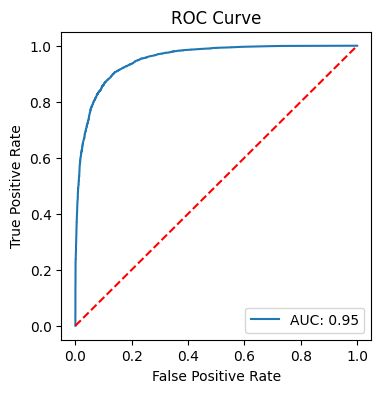

In [14]:
# get the probability of the positive class (>50k)
y_pred_proba = best_rf_classifier.predict_proba(X_test)[:, 1]

# get the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot the roc curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Train Naive Bayes Model

In [15]:
model = GaussianNB()

# Grid search
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy score found: ", grid_search.best_score_)

Best parameters found:  {'var_smoothing': 1e-09}
Best accuracy score found:  0.7202148476239023


In [16]:
best_NB_model = grid_search.best_estimator_
best_NB_model

GaussianNB()

In [17]:
# Predict testing data
y_pred = best_NB_model.predict(X_test)

# Predict Train data
y_pred_train = best_NB_model.predict(X_train)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Testing Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Training Accuracy: {accuracy_score(y_train, y_pred_train)}')

              precision    recall  f1-score   support

           0       0.67      0.84      0.75      6746
           1       0.79      0.60      0.68      6844

    accuracy                           0.72     13590
   macro avg       0.73      0.72      0.71     13590
weighted avg       0.73      0.72      0.71     13590

Testing Accuracy: 0.7183222958057395
Training Accuracy: 0.7204540437118258


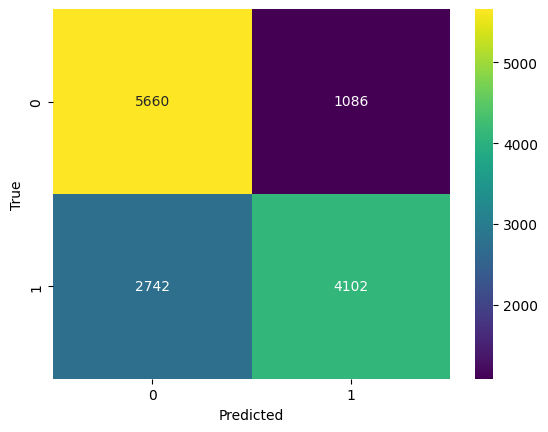

In [18]:
# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

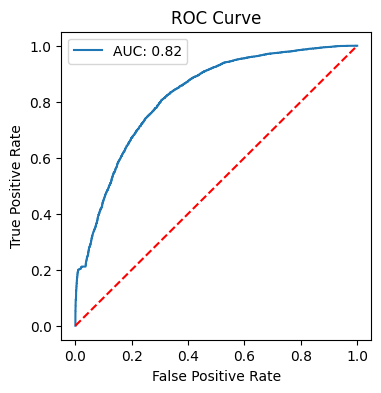

In [19]:
# get the probability of each class
y_pred_proba = best_NB_model.predict_proba(X_test)

# get the probability of the positive class (>50k)
y_pred_proba = y_pred_proba[:, 1]

# get the roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot the roc curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(y_test, y_pred_proba):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()